<a href="https://colab.research.google.com/github/ayeshakhalid17/real-vs-fake/blob/main/Training_from_Roboflow_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Install fastai dependencies

In [ ]:
!pip install fastai

In [ ]:
from fastai.vision import *

# Download Custom Classification Data From Roboflow

In [ ]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="folder", notebook="roboflow-resnet")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=folder&ref=roboflow-resnet


In [ ]:
rf = Roboflow(api_key="Y5QmNEIsnqC1R6vkcvER")
project = rf.workspace().project("real-vs-fake")
dataset = project.version(3).download("folder")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Real-vs-Fake-3 in folder:: 100%|██████████| 2175/2175 [00:01<00:00, 1149.37it/s]


In [ ]:
dataset.location

'/content/Real-vs-Fake-3'

In [ ]:
#build fastai dataset loader
import numpy as np
import os
np.random.seed(42)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path(dataset.location)
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#double check the data classes
data.classes

['fakehuman', 'horse', 'realcar', 'realhorse', 'realhuman', 'toycar']

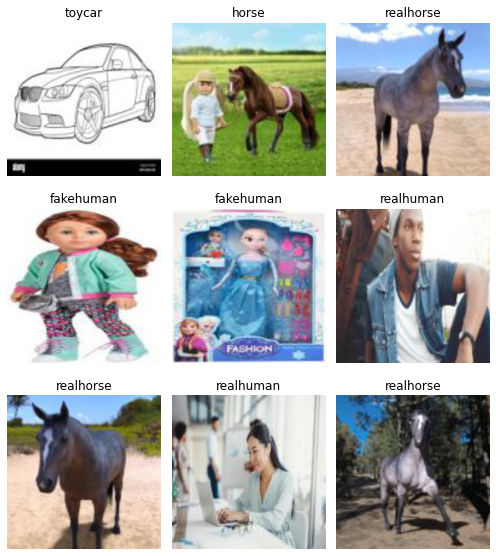

In [ ]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(rows=3, figsize=(7, 8))

# Set up fastai Resnet model

In [ ]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=[error_rate,accuracy])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
#print network layers
learn

Learner(data=ImageDataBunch;

Train: LabelList (1507 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fakehuman,fakehuman,fakehuman,fakehuman,fakehuman
Path: /content/Real-vs-Fake-3;

Valid: LabelList (430 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fakehuman,fakehuman,fakehuman,fakehuman,fakehuman
Path: /content/Real-vs-Fake-3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1):

# Train Custom Resnet Image Classifier

In [ ]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [ ]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4, callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.299552,0.297303,0.088372,0.911628,00:16
1,0.698004,0.207354,0.069767,0.930233,00:12
2,0.430401,0.189042,0.072093,0.927907,00:13
3,0.279762,0.197368,0.065116,0.934884,00:12


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.29730263352394104.
Better model found at epoch 1 with valid_loss value: 0.20735444128513336.
Better model found at epoch 2 with valid_loss value: 0.18904151022434235.


In [ ]:
#load best model from frozen training
learn.load('best_resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (1507 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fakehuman,fakehuman,fakehuman,fakehuman,fakehuman
Path: /content/Real-vs-Fake-3;

Valid: LabelList (430 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fakehuman,fakehuman,fakehuman,fakehuman,fakehuman
Path: /content/Real-vs-Fake-3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1):

In [ ]:
learn.unfreeze()

In [ ]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [ ]:
optimal_lr = find_appropriate_lr(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.fit_one_cycle(10, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.114174,0.191701,0.065116,0.934884,00:17
1,0.112472,0.186894,0.062791,0.937209,00:17
2,0.105838,0.190919,0.058140,0.941860,00:17
3,0.107985,0.190209,0.062791,0.937209,00:17
4,0.109867,0.192456,0.065116,0.934884,00:17
5,0.110114,0.189705,0.060465,0.939535,00:17
6,0.107599,0.189748,0.062791,0.937209,00:17
7,0.114657,0.190925,0.058140,0.941860,00:17
8,0.114074,0.192551,0.062791,0.937209,00:17
9,0.114550,0.187336,0.060465,0.939535,00:17


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.19170145690441132.
Better model found at epoch 1 with valid_loss value: 0.18689380586147308.


In [ ]:
learn.load('best_resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (1507 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fakehuman,fakehuman,fakehuman,fakehuman,fakehuman
Path: /content/Real-vs-Fake-3;

Valid: LabelList (430 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fakehuman,fakehuman,fakehuman,fakehuman,fakehuman
Path: /content/Real-vs-Fake-3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1):

# Evaluate Classifier Performance

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


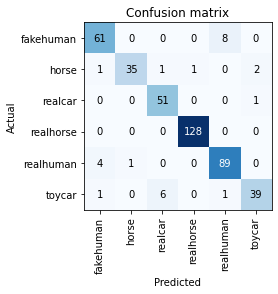

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

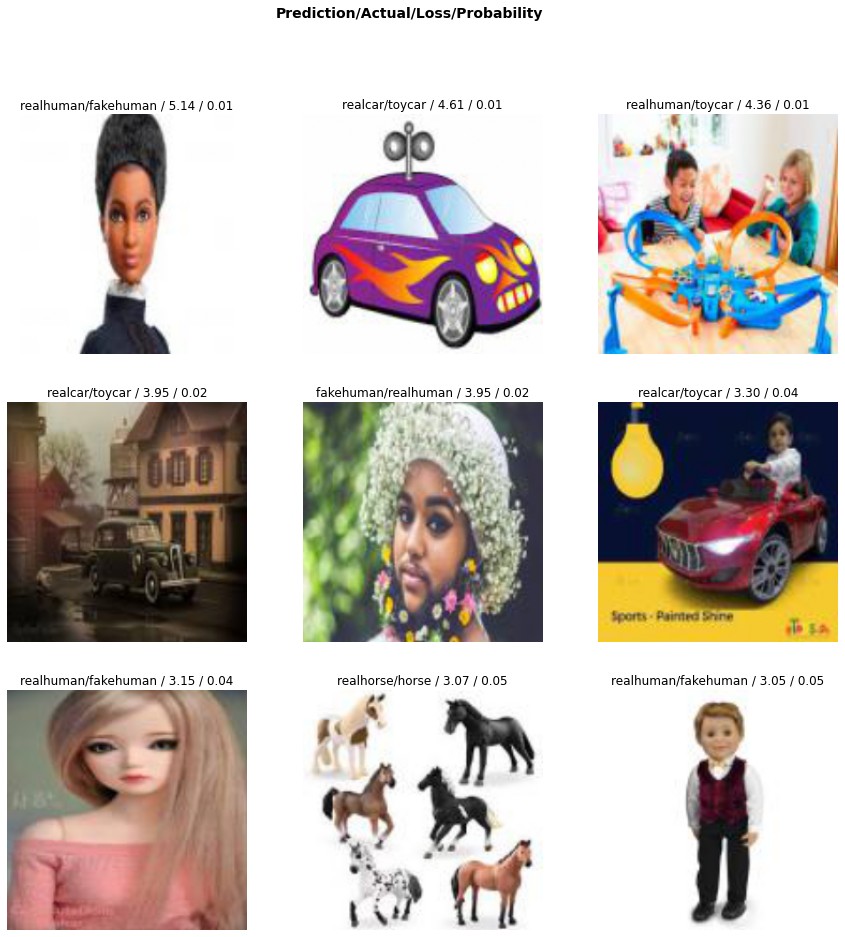

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

horse


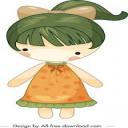



fakehuman


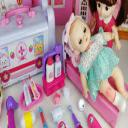



fakehuman


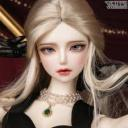



fakehuman


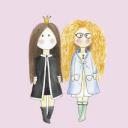



realhuman


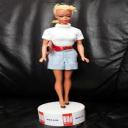



toycar


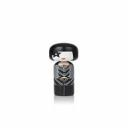



fakehuman


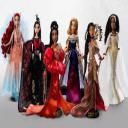



fakehuman


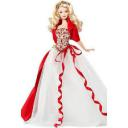



fakehuman


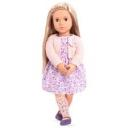



toycar


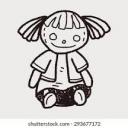



fakehuman


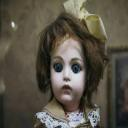



fakehuman


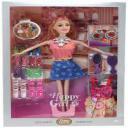



fakehuman


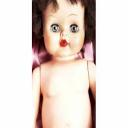



fakehuman


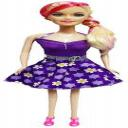



fakehuman


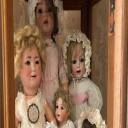



fakehuman


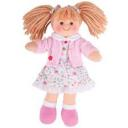



fakehuman


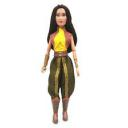



fakehuman


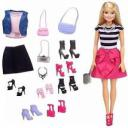



fakehuman


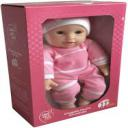



fakehuman


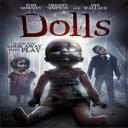



fakehuman


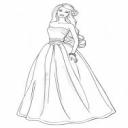



toycar


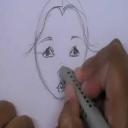



fakehuman


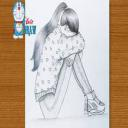



fakehuman


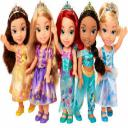



fakehuman


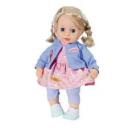



fakehuman


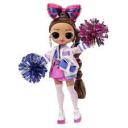



fakehuman


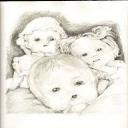



fakehuman


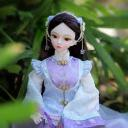



horse


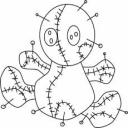



fakehuman


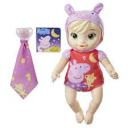



fakehuman


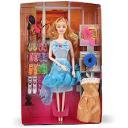



horse


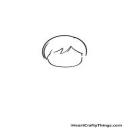



realcar


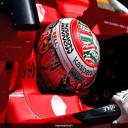



realcar


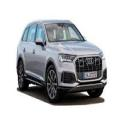



realcar


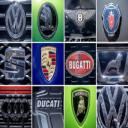



realcar


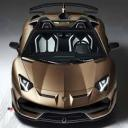



realcar


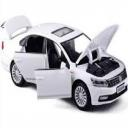



realcar


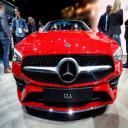



realcar


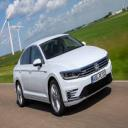



fakehuman


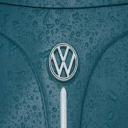



realcar


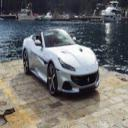



realcar


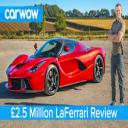



realcar


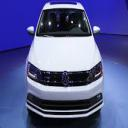



realcar


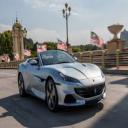



realcar


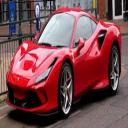



realcar


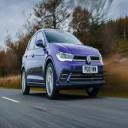



realcar


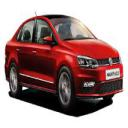



realcar


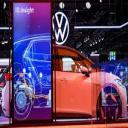



realcar


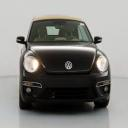



realcar


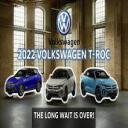



realcar


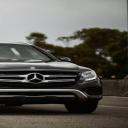



realcar


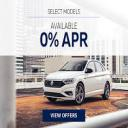



realcar


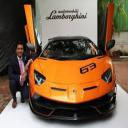



toycar


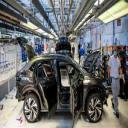



realcar


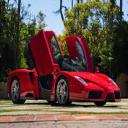



realcar


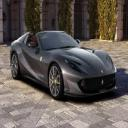



realhuman


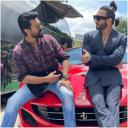



realcar


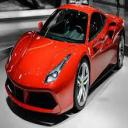



realcar


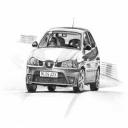



toycar


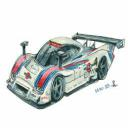



toycar


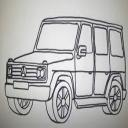



realcar


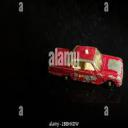



toycar


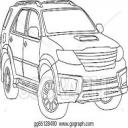



toycar


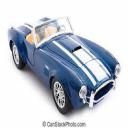



toycar


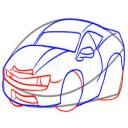



toycar


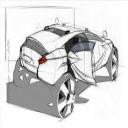



toycar


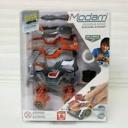



fakehuman


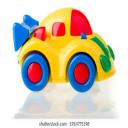



toycar


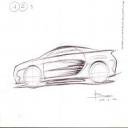



toycar


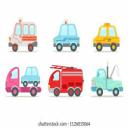



toycar


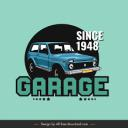



realcar


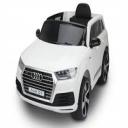



toycar


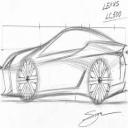



toycar


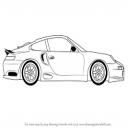



toycar


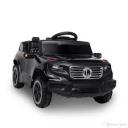



toycar


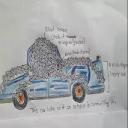



toycar


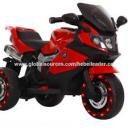



toycar


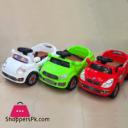



toycar


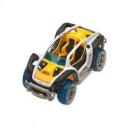



toycar


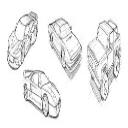



toycar


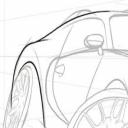



horse


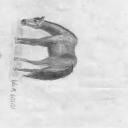



fakehuman


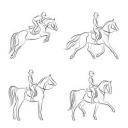



horse


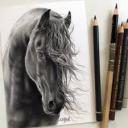



horse


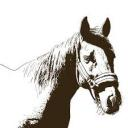



horse


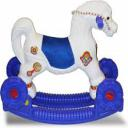



horse


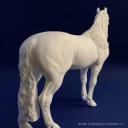



toycar


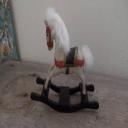



fakehuman


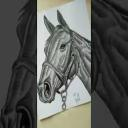



horse


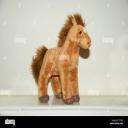



realhorse


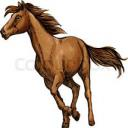



realhuman


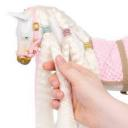



horse


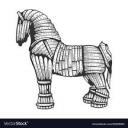



horse


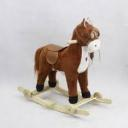



toycar


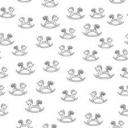



horse


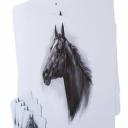



horse


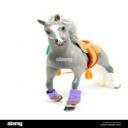



horse


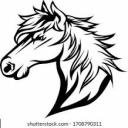



horse


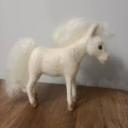



fakehuman


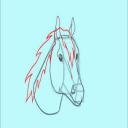



horse


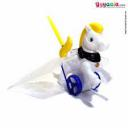



horse


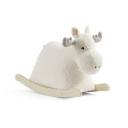



realhorse


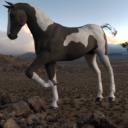



realhorse


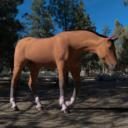



realhorse


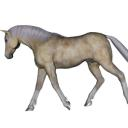



realhorse


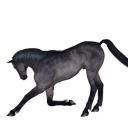



realhorse


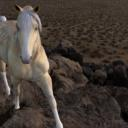



realhorse


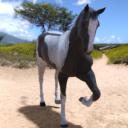



realhorse


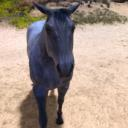



realhorse


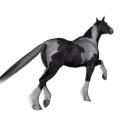



realhorse


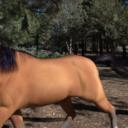



realhorse


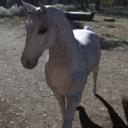



realhorse


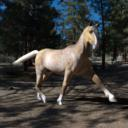



realhorse


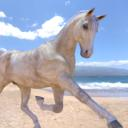



realhorse


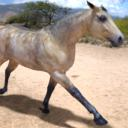



realhorse


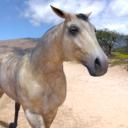



realhorse


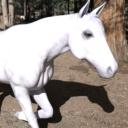



realhorse


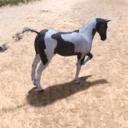



realhorse


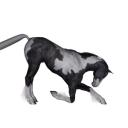



realhorse


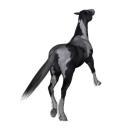



realhorse


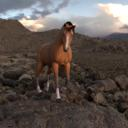



realhorse


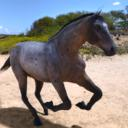



realhorse


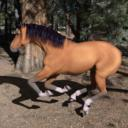



realhorse


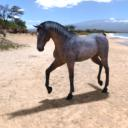



realhorse


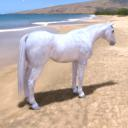



realhorse


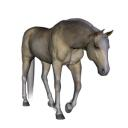



realhorse


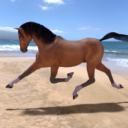



realhorse


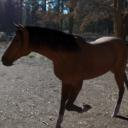



realhorse


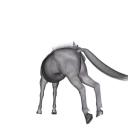



realhorse


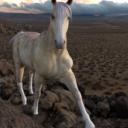



realhorse


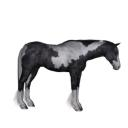



realhorse


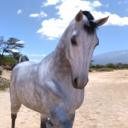



realhorse


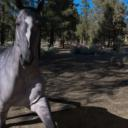



realhorse


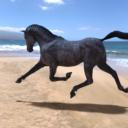



realhorse


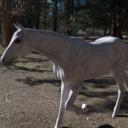



realhorse


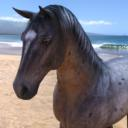



realhorse


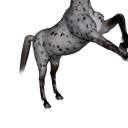



realhorse


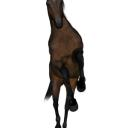



realhorse


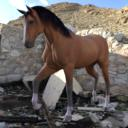



realhorse


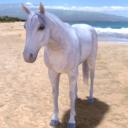



realhorse


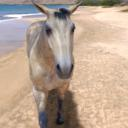



realhorse


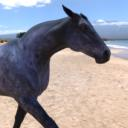



realhorse


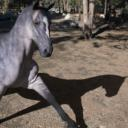



realhorse


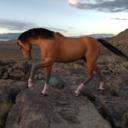



realhorse


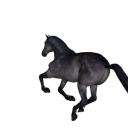



realhorse


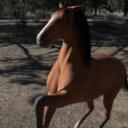



realhorse


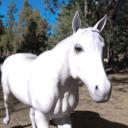



realhorse


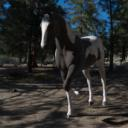



realhorse


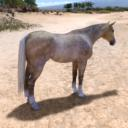



realhorse


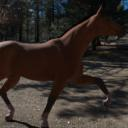



realhorse


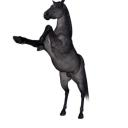



realhorse


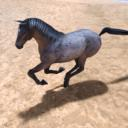



realhorse


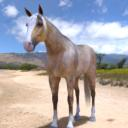



realhorse


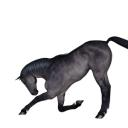



realhorse


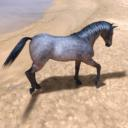



realhorse


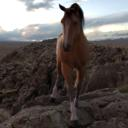



realhorse


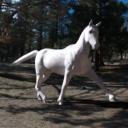



realhorse


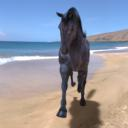



realhorse


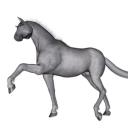



realhorse


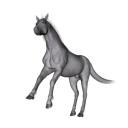



realhorse


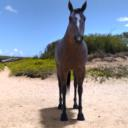



realhorse


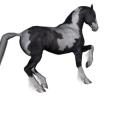



realhorse


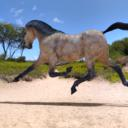



realhorse


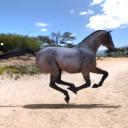



realhorse


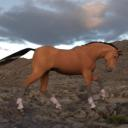



realhuman


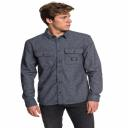



realhuman


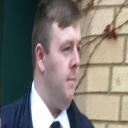



realhuman


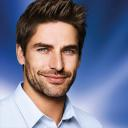



realhuman


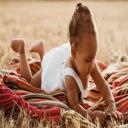



realhuman


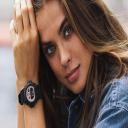



realhuman


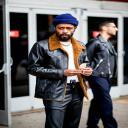



realhuman


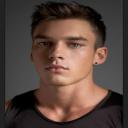



realhuman


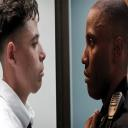



realhuman


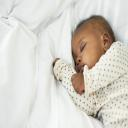



realhuman


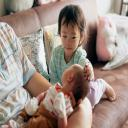



realhuman


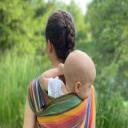



realhuman


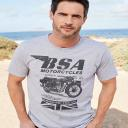



realhuman


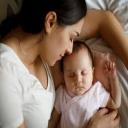



realhuman


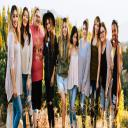



realhuman


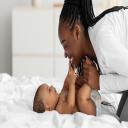



realhuman


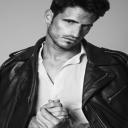



realhuman


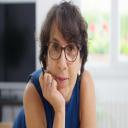



realhuman


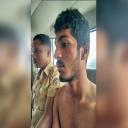



realhuman


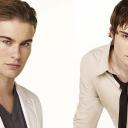



realhuman


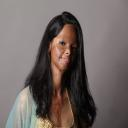



realhuman


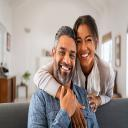



realhuman


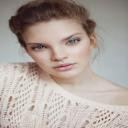



realhuman


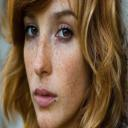



realhuman


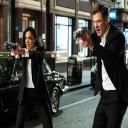



realhuman


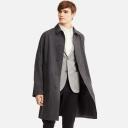



realhuman


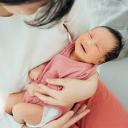



realhuman


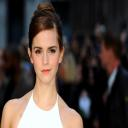



fakehuman


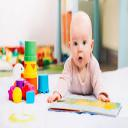



realhuman


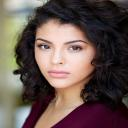



realhuman


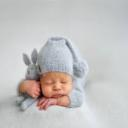



realhuman


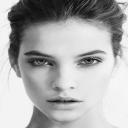



realhuman


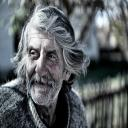



realhuman


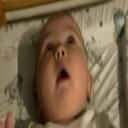



fakehuman


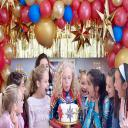



realhuman


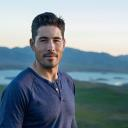



realhuman


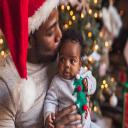



realhuman


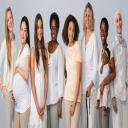



realhuman


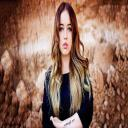



realhuman


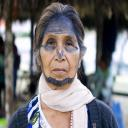



realhuman


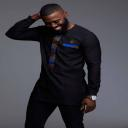



realhuman


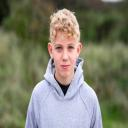



realhuman


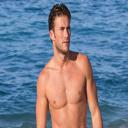



realhuman


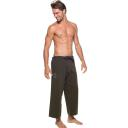



realhuman


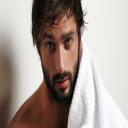



fakehuman


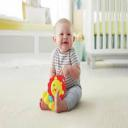



realhuman


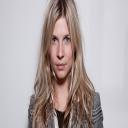



fakehuman


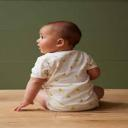



realhuman


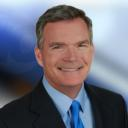



realhuman


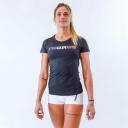



realhuman


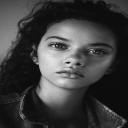

In [ ]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/Real-vs-Fake-3/test/*/*.jpg'):
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")